In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [3]:
# Get current working directory
import os
cwd = os.getcwd()
print("Current working directory:", cwd)
os.chdir("/Users/yanjidu/Library/CloudStorage/GoogleDrive-duyanji@g.ucla.edu/My Drive/Projects/Aging/Incubator2025_ComputationalLifeCourse_YD")

Current working directory: /Users/yanjidu/Library/CloudStorage/GoogleDrive-duyanji@g.ucla.edu/My Drive/Projects/Aging/Incubator2025_ComputationalLifeCourse_YD/Scripts/g_comp


In [4]:
import sys
sys.path.append("Scripts/g_comp")  # relative path from your current working directory

In [5]:
import g_comp_YD as gc

In [6]:
# Reload the module (if it's been edited and needs to be reloaded)
import importlib
importlib.reload(gc)

<module 'g_comp_YD' from '/Users/yanjidu/Library/CloudStorage/GoogleDrive-duyanji@g.ucla.edu/My Drive/Projects/Aging/Incubator2025_ComputationalLifeCourse_YD/Scripts/g_comp/g_comp_YD.py'>

In [7]:
def set_seed(seed =42):
    """Set seed for reproducibility across multiple libraries"""
    random.seed(seed)  # Python's built-in random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed_all(seed)  # PyTorch CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)  # Call this at the beginning of your code

In [8]:
## Load the data 
import pandas as pd
df = pd.read_csv("Data/Processed/g_data.csv")
df = df.sort_values(["mergeid", "t_age"]) 

In [9]:
## Check the number of dropped cases 
complete_y_adl_65_75_dic_mergeids = gc.summarize_mergeid_completeness(df, ["y_adl_65_75_dic", "dt_n_years_disease_dic"], "ADL 65–75")

[ADL 65–75]
Original mergeids: 20806
Complete mergeids (no missing values in Y): 14958
Number of unique mergeids dropped: 5848



In [10]:
###############
## Data prep ##
###############

# N = number of individuals, T = number of time points (i.e., 33)
# Generate datasets for pooled and by regime 
T = 33
df_adl_65_75 = gc.get_valid_df(df, complete_y_adl_65_75_dic_mergeids, "ADL 65–75", T)
df_adl_med_65_75 = df_adl_65_75[df_adl_65_75["mod_welfare_regime_mediterranean"] == 1.0]
df_adl_cor_65_75 = df_adl_65_75[df_adl_65_75["mod_welfare_regime_corporatist"] == 1.0]
df_adl_scan_65_75 = df_adl_65_75[df_adl_65_75["mod_welfare_regime_scandinavian"] == 1.0]
 

# Mediterranean 
feature_cols_outcome_med_65_75 = gc.get_feature_cols(df_adl_med_65_75, context="outcome and med")
feature_cols_tv_covar_med_65_75 = gc.get_feature_cols(df_adl_med_65_75, context="tv_covar and med")

# Corporatist
feature_cols_outcome_cor_65_75 = gc.get_feature_cols(df_adl_cor_65_75, context="outcome and cor")
feature_cols_tv_covar_cor_65_75 = gc.get_feature_cols(df_adl_cor_65_75, context="tv_covar and cor")

# Scandinavian
feature_cols_outcome_scan_65_75 = gc.get_feature_cols(df_adl_scan_65_75, context="outcome and scan")
feature_cols_tv_covar_scan_65_75 = gc.get_feature_cols(df_adl_scan_65_75, context="tv_covar and scan")


# Convert to (N, T, D) tensor
# Treatment and covariates from the dataset 
 
# Mediterranean 
N_adl_med_65_75 = df_adl_med_65_75['mergeid'].nunique()
X_adl_med_65_75 = gc.convert_df_to_X(df_adl_med_65_75, feature_cols_outcome_med_65_75, N_adl_med_65_75, T)
X_disease_med_65_75  = gc.convert_df_to_X(df_adl_med_65_75, feature_cols_tv_covar_med_65_75, N_adl_med_65_75, T)

# Corporatist
N_adl_cor_65_75 = df_adl_cor_65_75['mergeid'].nunique()
X_adl_cor_65_75 = gc.convert_df_to_X(df_adl_cor_65_75, feature_cols_outcome_cor_65_75, N_adl_cor_65_75, T)
X_disease_cor_65_75  = gc.convert_df_to_X(df_adl_cor_65_75, feature_cols_tv_covar_cor_65_75, N_adl_cor_65_75, T)

# Scandinavian
N_adl_scan_65_75 = df_adl_scan_65_75['mergeid'].nunique()
X_adl_scan_65_75 = gc.convert_df_to_X(df_adl_scan_65_75, feature_cols_outcome_scan_65_75, N_adl_scan_65_75, T)
X_disease_scan_65_75  = gc.convert_df_to_X(df_adl_scan_65_75, feature_cols_tv_covar_scan_65_75, N_adl_scan_65_75, T)

[ADL 65–75]
Mergeids with complete outcome and 33 unique ages: 14958
[get_feature_cols] Context: outcome and med | Exclude: ['mod_country_italy']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and med | Exclude: ['mod_country_italy', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and cor | Exclude: ['mod_country_germany']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and cor | Exclude: ['mod_country_germany', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded
[get_feature_cols] Context: outcome and scan | Exclude: ['mod_country_sweden']
⚠️ dt_n_years_disease_dic IS STILL INCLUDED
[get_feature_cols] Context: tv_covar and scan | Exclude: ['mod_country_sweden', 'dt_n_years_disease_dic']
✅ dt_n_years_disease_dic successfully excluded


In [12]:
# Initialize results df with IDs and Cluster

df_adl_med_65_75_results = df_adl_med_65_75.groupby(['mergeid', 'cluster']).size().reset_index()[['mergeid', 'cluster']]
df_adl_cor_65_75_results = df_adl_cor_65_75.groupby(['mergeid', 'cluster']).size().reset_index()[['mergeid', 'cluster']]
df_adl_scan_65_75_results = df_adl_scan_65_75.groupby(['mergeid', 'cluster']).size().reset_index()[['mergeid', 'cluster']]

In [13]:
# Remap cluster name to medoid ID

cluster_medoid_map = {
    'Cluster 1: FT w Child': 'medoid_0', 
    'Cluster 2: FT w/o Child': 'medoid_1', 
    'Cluster 3: UE w Child': 'medoid_2',
    'Cluster 4: PT w Child': 'medoid_3'
}

df_adl_med_65_75_results['medoid'] = df_adl_med_65_75_results['cluster'].map(cluster_medoid_map)
df_adl_cor_65_75_results['medoid'] = df_adl_cor_65_75_results['cluster'].map(cluster_medoid_map)
df_adl_scan_65_75_results['medoid'] = df_adl_scan_65_75_results['cluster'].map(cluster_medoid_map)

In [15]:
###############
## Y and L_t ##
###############

# Binary outcomes  
y_adl_med_65_75_dic = gc.extract_y_tensor(df_adl_med_65_75, "y_adl_65_75_dic")
y_adl_cor_65_75_dic = gc.extract_y_tensor(df_adl_cor_65_75, "y_adl_65_75_dic")
y_adl_scan_65_75_dic = gc.extract_y_tensor(df_adl_scan_65_75, "y_adl_65_75_dic")

# Binary outcomes for tv covar 
# Mediterranean 
y_disease_med_65_75_dic = gc.extract_y_tensor(df_adl_med_65_75, "dt_n_years_disease_dic")
y_disease_cor_65_75_dic = gc.extract_y_tensor(df_adl_cor_65_75, "dt_n_years_disease_dic")
y_disease_scan_65_75_dic = gc.extract_y_tensor(df_adl_scan_65_75, "dt_n_years_disease_dic")

In [16]:
#####################
## \vec{a} and L_0 ##
#####################

# Extract high-level treatment trajectory features with covariates for each X matrix


# Mediterranean
X_med_features_adl_65_75_dic = gc.extract_features(X_adl_med_65_75, feature_cols_outcome_med_65_75)
X_med_features_disease_65_75_dic  = gc.extract_features(X_disease_med_65_75, feature_cols_tv_covar_med_65_75)

# Corporatist
X_cor_features_adl_65_75_dic = gc.extract_features(X_adl_cor_65_75, feature_cols_outcome_cor_65_75)
X_cor_features_disease_65_75_dic  = gc.extract_features(X_disease_cor_65_75, feature_cols_tv_covar_cor_65_75)

# Scandinavian
X_scan_features_adl_65_75_dic = gc.extract_features(X_adl_scan_65_75, feature_cols_outcome_scan_65_75)
X_scan_features_disease_65_75_dic  = gc.extract_features(X_disease_scan_65_75, feature_cols_tv_covar_scan_65_75)

In [17]:
############################
## Tuning for best models ##
############################
# Best models for med sample 
y_adl_med_65_75_dic_model, y_adl_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_adl_65_75_dic, y_adl_med_65_75_dic, "adl 65–75 (med)", save_dir="model_outputs/adl/med")
y_disease_med_65_75_dic_model, y_disease_med_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, "disease 65–75 (med)", save_dir="model_outputs/adl/med")

/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:45:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:45:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




=== adl 65–75 (med) ===
Train Accuracy: 0.680327868852459
Test Accuracy: 0.6409348441926346
Test AUC: 0.693135560140523


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:46:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:46:24] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




=== disease 65–75 (med) ===
Train Accuracy: 0.5807528840315725
Test Accuracy: 0.5835694050991501
Test AUC: 0.6085126065491754


In [19]:
# Best models for cor sample 
y_adl_cor_65_75_dic_model, y_adl_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_adl_65_75_dic, y_adl_cor_65_75_dic, "adl 65–75 (cor)", save_dir="model_outputs/adl/cor")
y_disease_cor_65_75_dic_model, y_disease_cor_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, "disease 65–75 (cor)", save_dir="model_outputs/adl/cor")

/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:42] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:42] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt


=== adl 65–75 (cor) ===
Train Accuracy: 0.7582268679829656
Test Accuracy: 0.6288939051918736
Test AUC: 0.6467889908256881


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:49:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:49:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:49:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt


=== disease 65–75 (cor) ===
Train Accuracy: 0.6345334881920248
Test Accuracy: 0.5986455981941309
Test AUC: 0.6058139993427539


In [20]:
# Best models for scan sample 
y_adl_scan_65_75_dic_model, y_adl_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_adl_65_75_dic, y_adl_scan_65_75_dic, "adl 65–75 (scan)", save_dir="model_outputs/adl/scan")
y_disease_scan_65_75_dic_model, y_disease_scan_65_75_dic_best_models = gc.train_and_evaluate_with_tuning(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, "disease 65–75 (scan)", save_dir="model_outputs/adl/scan")

/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-pack


=== adl 65–75 (scan) ===
Train Accuracy: 0.6192135390741662
Test Accuracy: 0.6218097447795824
Test AUC: 0.6326029394834798


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/gcomp/lib/python3.10/site-pack


=== disease 65–75 (scan) ===
Train Accuracy: 0.7486311597809856
Test Accuracy: 0.617169373549884
Test AUC: 0.6609063390313391


In [21]:
#############################
## Counterfactual analysis ## 
#############################

import pandas as pd
medoid_df = pd.read_csv("Data/Processed/medoid_seq_data.csv")
# Your custom emodid order
custom_order = ['AT-148850-02', 'GR-336206-02', 'Bn-067069-02', 'IT-813620-01']

# Reorder DataFrame based on this order
medoid_df = medoid_df.sort_values(["mergeid", "t_age"]) 
medoid_df = medoid_df.set_index('mergeid').loc[custom_order].reset_index()

N_medoid = medoid_df['mergeid'].nunique()
X_medoid_adl_65_75_dic   = gc.convert_df_to_X(medoid_df, feature_cols_outcome_med_65_75, N_medoid, T)
X_medoid_disease_65_75_dic  = gc.convert_df_to_X(medoid_df, feature_cols_tv_covar_med_65_75, N_medoid, T)
X_medoid_features_65_75_dic   = gc.extract_treatment_features_from_medoid(X_medoid_adl_65_75_dic, feature_cols_outcome_med_65_75) 

In [22]:
 
# Mediterranean regime
X_features_disease_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_features_adl_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Corporatist regime
X_cor_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_cor_features_adl_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Scandinavian regime
X_scan_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_scan_features_adl_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)


In [34]:
################################################# 
## refit the final model with all origina data ##
#################################################
 
 
# Mediterranean models
y_adl_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_adl_65_75_dic,
    y=y_adl_med_65_75_dic,
    base_models=y_adl_med_65_75_dic_best_models,
    label="adl 65–75 (med)",
    save=True
)

y_disease_med_final_models = gc.refit_and_save_final_models(
    X=X_med_features_disease_65_75_dic,
    y=y_disease_med_65_75_dic,
    base_models=y_disease_med_65_75_dic_best_models,
    label="disease 65–75 (med)",
    save=True
)

y_adl_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_adl_65_75_dic,
    y=y_adl_med_65_75_dic,
    base_models=y_adl_med_final_models,
    label="adl 65–75 (med)",
    save=True
)

y_disease_med_super_learner = gc.refit_and_save_super_learner(
    X=X_med_features_disease_65_75_dic,
    y=y_disease_med_65_75_dic,
    base_models=y_disease_med_final_models,
    label="disease 65–75 (med)",
    save=True
)


# Corporatist models
y_adl_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_adl_65_75_dic,
    y=y_adl_cor_65_75_dic,
    base_models=y_adl_cor_65_75_dic_best_models,
    label="adl 65–75 (cor)",
    save=True
)

y_disease_cor_final_models = gc.refit_and_save_final_models(
    X=X_cor_features_disease_65_75_dic,
    y=y_disease_cor_65_75_dic,
    base_models= y_disease_cor_65_75_dic_best_models,
    label="disease 65–75 (cor)",
    save=True
)

y_adl_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_adl_65_75_dic,
    y=y_adl_cor_65_75_dic,
    base_models=y_adl_cor_final_models,
    label="adl 65–75 (cor)",
    save=True
)

y_disease_cor_super_learner = gc.refit_and_save_super_learner(
    X=X_cor_features_disease_65_75_dic,
    y=y_disease_cor_65_75_dic,
    base_models=y_disease_cor_final_models,
    label="disease 65–75 (cor)",
    save=True
)


# Scandinavian models
y_adl_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_adl_65_75_dic,
    y=y_adl_scan_65_75_dic,
    base_models=y_adl_scan_65_75_dic_best_models,
    label="adl 65–75 (scan)",
    save=True
)

y_disease_scan_final_models = gc.refit_and_save_final_models(
    X=X_scan_features_disease_65_75_dic,
    y=y_disease_scan_65_75_dic,
    base_models=y_disease_scan_65_75_dic_best_models,
    label="disease 65–75 (scan)",
    save=True
)

y_adl_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_adl_65_75_dic,
    y=y_adl_scan_65_75_dic,
    base_models=y_adl_scan_final_models,
    label="adl 65–75 (scan)",
    save=True
)

y_disease_scan_super_learner = gc.refit_and_save_super_learner(
    X=X_scan_features_disease_65_75_dic,
    y=y_disease_scan_65_75_dic,
    base_models=y_disease_scan_final_models,
    label="disease 65–75 (scan)",
    save=True
)

###########################################
## Hypothetical intervention with medoid ##
###########################################

 
# Mediterranean 
X_features_disease_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_features_adl_med_65_75_dic_updated_list = gc.generate_updated_list(
    X_med_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Corporatist 
X_cor_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_cor_features_adl_65_75_dic_updated_list = gc.generate_updated_list(
    X_cor_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

# Scandinavian 
X_scan_features_disease_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_disease_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)

X_scan_features_adl_65_75_dic_updated_list = gc.generate_updated_list(
    X_scan_features_adl_65_75_dic, X_medoid_features_65_75_dic, cols_to_replace=30)


🔁 Refitting LASSO on full data...
✅ Saved LASSO refitted model to: intermediate/adl_65-75_(med)_lasso_final_model.pkl

🔁 Refitting RF on full data...


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate/adl_65-75_(med)_rf_final_model.pkl

🔁 Refitting XGB on full data...
✅ Saved XGB refitted model to: intermediate/adl_65-75_(med)_xgb_final_model.pkl

🔁 Refitting LASSO on full data...


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:22:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


✅ Saved LASSO refitted model to: intermediate/disease_65-75_(med)_lasso_final_model.pkl

🔁 Refitting RF on full data...


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Saved RF refitted model to: intermediate/disease_65-75_(med)_rf_final_model.pkl

🔁 Refitting XGB on full data...
✅ Saved XGB refitted model to: intermediate/disease_65-75_(med)_xgb_final_model.pkl

🔁 Fitting SUPER LEARNER for adl 65–75 (med)...


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:22:12] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/xgboost/training.py:183: 

✅ Saved SUPER LEARNER to: intermediate/adl_65-75_(med)_super_learner.pkl

🔁 Fitting SUPER LEARNER for disease 65–75 (med)...


/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/gcomp/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


KeyboardInterrupt: 

In [27]:
from sklearn.utils import resample

# They are common  
 
trt_features_med_adl_65_75_dic   = gc.create_feature_df(X_med_features_adl_65_75_dic, feature_cols_outcome_med_65_75, "adl 65–75")
trt_features_cor_adl_65_75_dic   = gc.create_feature_df(X_cor_features_adl_65_75_dic, feature_cols_outcome_cor_65_75, "adl 65–75")
trt_features_scan_adl_65_75_dic   = gc.create_feature_df(X_scan_features_adl_65_75_dic, feature_cols_outcome_scan_65_75, "adl 65–75")


def run_mc_bootstrap_once_regime_fixed_model(seed):
    # Step 1: Bootstrap indices
    def bootstrap(X, y, seed):
        idx = resample(np.arange(len(X)), replace=True, n_samples=len(X), random_state=seed)
        return X[idx], y[idx]
 

    X_mob_med, y_mob_med = bootstrap(X_med_features_adl_65_75_dic, y_adl_med_65_75_dic, seed+1)
    X_dis_med, _ = bootstrap(X_med_features_disease_65_75_dic, y_disease_med_65_75_dic, seed+1)

    X_mob_scan, y_mob_scan = bootstrap(X_scan_features_adl_65_75_dic, y_adl_scan_65_75_dic, seed+2)
    X_dis_scan, _ = bootstrap(X_scan_features_disease_65_75_dic, y_disease_scan_65_75_dic, seed+2)

    X_mob_corp, y_mob_corp = bootstrap(X_cor_features_adl_65_75_dic, y_adl_cor_65_75_dic, seed+3)
    X_dis_corp, _ = bootstrap(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, seed+3)

    # Step 2: Update with medoid features
    def update_with_medoids(X_dis, X_mob):
        return gc.generate_updated_list(X_dis, X_medoid_features_65_75_dic, cols_to_replace=30), \
               gc.generate_updated_list(X_mob, X_medoid_features_65_75_dic, cols_to_replace=30)
 
    X_dis_med_updated, X_mob_med_updated = update_with_medoids(X_dis_med, X_mob_med)
    X_dis_scan_updated, X_mob_scan_updated = update_with_medoids(X_dis_scan, X_mob_scan)
    X_dis_corp_updated, X_mob_corp_updated = update_with_medoids(X_dis_corp, X_mob_corp)

    # Step 3: Use pre-trained models (must be defined globally or passed in)
    # e.g., sl_dis, sl_mob, etc. are pre-trained super learners
 
    _, _, ates_med, stand_ates_med, risk_ratios_med, atts_med = gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_med_super_learner,
        y_model=y_adl_med_super_learner,
        y_dic=y_mob_med,
        X_features_disease_65_75_dic_updated_list=X_dis_med_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_med_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_med_adl_65_75_dic.columns.tolist(),
        results_df=df_adl_med_65_75_results
    )

    _, _, ates_cor, stand_ates_cor, risk_ratios_cor, atts_cor =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_cor_super_learner,
        y_model=y_adl_cor_super_learner,
        y_dic=y_mob_corp,
        X_features_disease_65_75_dic_updated_list=X_dis_corp_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_corp_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_cor_adl_65_75_dic.columns.tolist(),
        results_df=df_adl_cor_65_75_results
    )

    _, _, ates_scan, stand_ates_scan, risk_ratios_scan, atts_scan =  gc.counterfactual_y_under_X_medoid_features(
        tv_cov_model=y_disease_scan_super_learner,
        y_model=y_adl_scan_super_learner,
        y_dic=y_mob_scan,
        X_features_disease_65_75_dic_updated_list=X_dis_scan_updated,
        X_features_outcome_65_75_dic_updated_list=X_mob_scan_updated,
        tv_cov_name="dt_n_years_disease_dic",
        outcome_feature_names=trt_features_scan_adl_65_75_dic.columns.tolist(),
        results_df=df_adl_scan_65_75_results
    )

    # Step 4: Format results
    ate_result = {"seed": seed} 
    ate_result.update(gc.flatten_ates_dict(ates_med, "Mediterranean"))
    ate_result.update(gc.flatten_ates_dict(ates_cor, "Corporatist"))
    ate_result.update(gc.flatten_ates_dict(ates_scan, "Scandinavian"))

    stand_ate_result = {"seed": seed} 
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_med, "Mediterranean"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_cor, "Corporatist"))
    stand_ate_result.update(gc.flatten_ates_dict(stand_ates_scan, "Scandinavian"))
    
    risk_ratio_result = {"seed": seed} 
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_med, "Mediterranean"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_cor, "Corporatist"))
    risk_ratio_result.update(gc.flatten_ates_dict(risk_ratios_scan, "Scandinavian"))

    att_result = {"seed": seed} 
    att_result.update(gc.flatten_ates_dict(atts_med, "Mediterranean"))
    att_result.update(gc.flatten_ates_dict(atts_cor, "Corporatist"))
    att_result.update(gc.flatten_ates_dict(atts_scan, "Scandinavian"))
    

    return ate_result, stand_ate_result, risk_ratio_result, att_result



adl 65–75: Feature dataframe shape = (4706, 48)
adl 65–75: Feature dataframe shape = (7381, 48)
adl 65–75: Feature dataframe shape = (2871, 48)


In [28]:
results_adl_65_75_dic = [run_mc_bootstrap_once_regime_fixed_model(seed) for seed in range(42, 45)]
df_results_adl_65_75_dic = pd.DataFrame(results_adl_65_75_dic)


--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.001
 Potential outcome: mean=0.111
 Relative average treatment effects: -0.244: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.005
 Potential outcome: mean=0.164
 Relative average treatment effects: 0.109: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.003
 Potential outcome: mean=0.130
 Relative average treatment effects: -0.119: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.007
 Potential outcome: mean=0.152
 Relative average treatment effects: 0.028: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.000
 Potential outcome: mean=0.115
 Relative average treatment effects: -0.293: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_diseas

In [29]:
# Fixed modles 
# Separate outcome models 

from joblib import Parallel, delayed
import pandas as pd
import time

start = time.time()

# Define number of bootstrap replicates and parallel jobs
n_bootstrap = 1000  # or any number you like
n_jobs = 8 
batch_size = 15

# Run bootstrap in parallel
bootstrap_results_adl_65_75_dic = Parallel(n_jobs=n_jobs, batch_size = batch_size)(
    delayed(run_mc_bootstrap_once_regime_fixed_model)(seed) for seed in range(42, 42 + n_bootstrap)
)

end = time.time()
print(f"Finished 1000 bootstraps in {(end - start)/60:.2f} minutes")

# Convert to DataFrame
df_bootstrap_results_adl_65_75_dic = pd.DataFrame(bootstrap_results_adl_65_75_dic)



--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.003
 Potential outcome: mean=0.112
 Relative average treatment effects: -0.304: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.006
 Potential outcome: mean=0.165
 Relative average treatment effects: 0.020: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.004
 Potential outcome: mean=0.131
 Relative average treatment effects: -0.189: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.008
 Potential outcome: mean=0.153
 Relative average treatment effects: -0.054: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.001
 Potential outcome: mean=0.116
 Relative average treatment effects: -0.290: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disea

In [30]:
df_bootstrap_results_adl_65_75_dic

,0,1,2,3
0,"{'seed': 42, 'Mediterranean_medoid_0': -0.0360...","{'seed': 42, 'Mediterranean_medoid_0': -0.2441...","{'seed': 42, 'Mediterranean_medoid_0': 0.75581...","{'seed': 42, 'Mediterranean_medoid_0': -0.0409..."
1,"{'seed': 43, 'Mediterranean_medoid_0': -0.0444...","{'seed': 43, 'Mediterranean_medoid_0': -0.2828...","{'seed': 43, 'Mediterranean_medoid_0': 0.71712...","{'seed': 43, 'Mediterranean_medoid_0': -0.0350..."
2,"{'seed': 44, 'Mediterranean_medoid_0': -0.0489...","{'seed': 44, 'Mediterranean_medoid_0': -0.3037...","{'seed': 44, 'Mediterranean_medoid_0': 0.69629...","{'seed': 44, 'Mediterranean_medoid_0': -0.0598..."
3,"{'seed': 45, 'Mediterranean_medoid_0': -0.0461...","{'seed': 45, 'Mediterranean_medoid_0': -0.2907...","{'seed': 45, 'Mediterranean_medoid_0': 0.70920...","{'seed': 45, 'Mediterranean_medoid_0': -0.0450..."
4,"{'seed': 46, 'Mediterranean_medoid_0': -0.0500...","{'seed': 46, 'Mediterranean_medoid_0': -0.3129...","{'seed': 46, 'Mediterranean_medoid_0': 0.68701...","{'seed': 46, 'Mediterranean_medoid_0': -0.0638..."
...,...,...,...,...
995,"{'seed': 1037, 'Mediterranean_medoid_0': -0.05...","{'seed': 1037, 'Mediterranean_medoid_0': -0.32...","{'seed': 1037, 'Mediterranean_medoid_0': 0.670...","{'seed': 1037, 'Mediterranean_medoid_0': -0.04..."
996,"{'seed': 1038, 'Mediterranean_medoid_0': -0.04...","{'seed': 1038, 'Mediterranean_medoid_0': -0.29...","{'seed': 1038, 'Mediterranean_medoid_0': 0.705...","{'seed': 1038, 'Mediterranean_medoid_0': -0.05..."
997,"{'seed': 1039, 'Mediterranean_medoid_0': -0.04...","{'seed': 1039, 'Mediterranean_medoid_0': -0.28...","{'seed': 1039, 'Mediterranean_medoid_0': 0.714...","{'seed': 1039, 'Mediterranean_medoid_0': -0.03..."
998,"{'seed': 1040, 'Mediterranean_medoid_0': -0.05...","{'seed': 1040, 'Mediterranean_medoid_0': -0.31...","{'seed': 1040, 'Mediterranean_medoid_0': 0.685...","{'seed': 1040, 'Mediterranean_medoid_0': -0.05..."


In [31]:
# Separate out raw ATE, standardized ATE, risk ratio and raw ATT results
raw_ate_results_adl_65_75_dic = [r[0] for r in bootstrap_results_adl_65_75_dic]
std_ate_results_adl_65_75_dic = [r[1] for r in bootstrap_results_adl_65_75_dic]
risk_ratio_results_adl_65_75_dic = [r[2] for r in bootstrap_results_adl_65_75_dic]
raw_att_results_adl_65_75_dic = [r[3] for r in bootstrap_results_adl_65_75_dic]

df_raw_ate_adl_65_75_dic = pd.DataFrame(raw_ate_results_adl_65_75_dic)
df_std_ate_adl_65_75_dic = pd.DataFrame(std_ate_results_adl_65_75_dic)
df_risk_ratio_adl_65_75_dic = pd.DataFrame(risk_ratio_results_adl_65_75_dic)
df_raw_att_adl_65_75_dic = pd.DataFrame(raw_att_results_adl_65_75_dic)

In [32]:
df_raw_ate_summary_adl_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_raw_ate_adl_65_75_dic)
df_std_ate_summary_adl_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_std_ate_adl_65_75_dic)
df_risk_ratio_summary_adl_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_risk_ratio_adl_65_75_dic)
df_raw_att_summary_adl_65_75_dic = gc.summarize_bootstrap_percentile_ci(df_raw_att_adl_65_75_dic)

In [33]:
# Save
gc.save_results_df(df_raw_ate_adl_65_75_dic, prefix = "raw_ate_df", label="adl 65–75")
gc.save_results_df(df_std_ate_adl_65_75_dic, prefix = "std_ate_df", label="adl 65–75")
gc.save_results_df(df_risk_ratio_adl_65_75_dic, prefix = "risk_ratio_df", label="adl 65–75")
gc.save_results_df(df_raw_att_adl_65_75_dic, prefix = "raw_att_df", label="adl 65–75")

gc.save_results_df(df_raw_ate_summary_adl_65_75_dic, prefix = "raw_ate_summary", label="adl 65–75")
gc.save_results_df(df_std_ate_summary_adl_65_75_dic, prefix = "std_ate_summary", label="adl 65–75")
gc.save_results_df(df_risk_ratio_summary_adl_65_75_dic, prefix = "risk_ratio_summary", label="adl 65–75")
gc.save_results_df(df_raw_att_summary_adl_65_75_dic, prefix = "raw_att_summary", label="adl 65–75")

Saved: Results/raw_ate_df_adl_65-75_all.csv
Saved: Results/std_ate_df_adl_65-75_all.csv
Saved: Results/risk_ratio_df_adl_65-75_all.csv
Saved: Results/raw_att_df_adl_65-75_all.csv
Saved: Results/raw_ate_summary_adl_65-75_all.csv
Saved: Results/std_ate_summary_adl_65-75_all.csv
Saved: Results/risk_ratio_summary_adl_65-75_all.csv
Saved: Results/raw_att_summary_adl_65-75_all.csv



=== Permutation Importance (Super Learner) ===
                    feature  importance_mean  importance_std
4       years_with_children         0.145836        0.004284
2               years_cohab         0.106423        0.008642
3           years_not_cohab         0.097487        0.006629
5    years_without_children         0.087796        0.004822
44            pre_edu_years         0.081244        0.006983
30   dt_n_years_disease_dic         0.034875        0.002717
33     pre_selfrated_health         0.022832        0.003339
31              pre_yrbirth         0.008815        0.000370
15              trans_cohab         0.004616        0.001936
41          pre_total_accom         0.003178        0.001429
16           first_fulltime         0.002270        0.000342
32      pre_ch_n_child_cond         0.002161        0.001008
39              pre_room_pp         0.002075        0.000661
38            pre_people_hh         0.001996        0.000729
1             cum_part_time         0

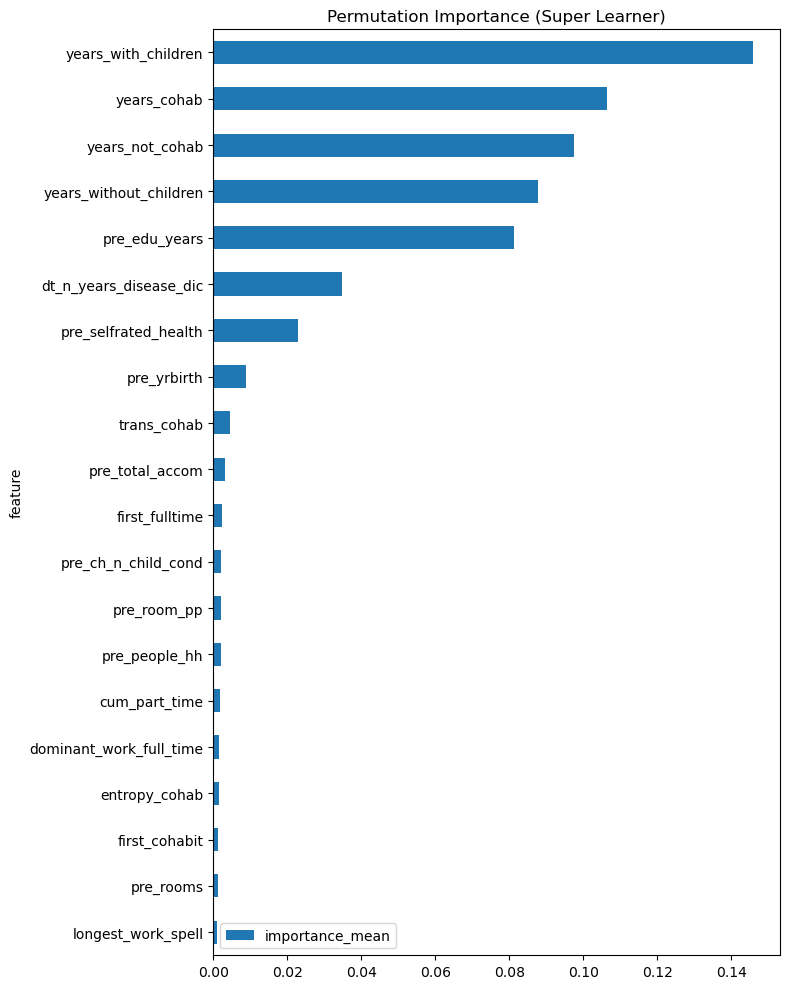

In [29]:
gc.plot_super_learner_permutation_importance(X = X_med_features_adl_65_75_dic, 
                                             y = y_adl_med_65_75_dic, 
                                             model = y_adl_med_super_learner, 
                                             feature_names = trt_features_med_adl_65_75_dic.columns.tolist(), 
                                             label = "adl 65-75 (med)", output_dir="model_outputs/adl/med")


=== Permutation Importance (Super Learner) ===
                   feature  importance_mean  importance_std
4      years_with_children         0.102440        0.006491
5   years_without_children         0.091285        0.005867
3          years_not_cohab         0.085315        0.004280
2              years_cohab         0.078095        0.007124
30  dt_n_years_disease_dic         0.053827        0.003382
0            cum_full_time         0.034018        0.001502
31             pre_yrbirth         0.016884        0.000606
23   last_work_not_working         0.015552        0.004318
33    pre_selfrated_health         0.014511        0.002042
16          first_fulltime         0.011881        0.001412
39             pre_room_pp         0.010710        0.000522
32     pre_ch_n_child_cond         0.010548        0.002782
14              trans_work         0.010390        0.001787
44           pre_edu_years         0.009501        0.000344
29           entropy_cohab         0.008604        0

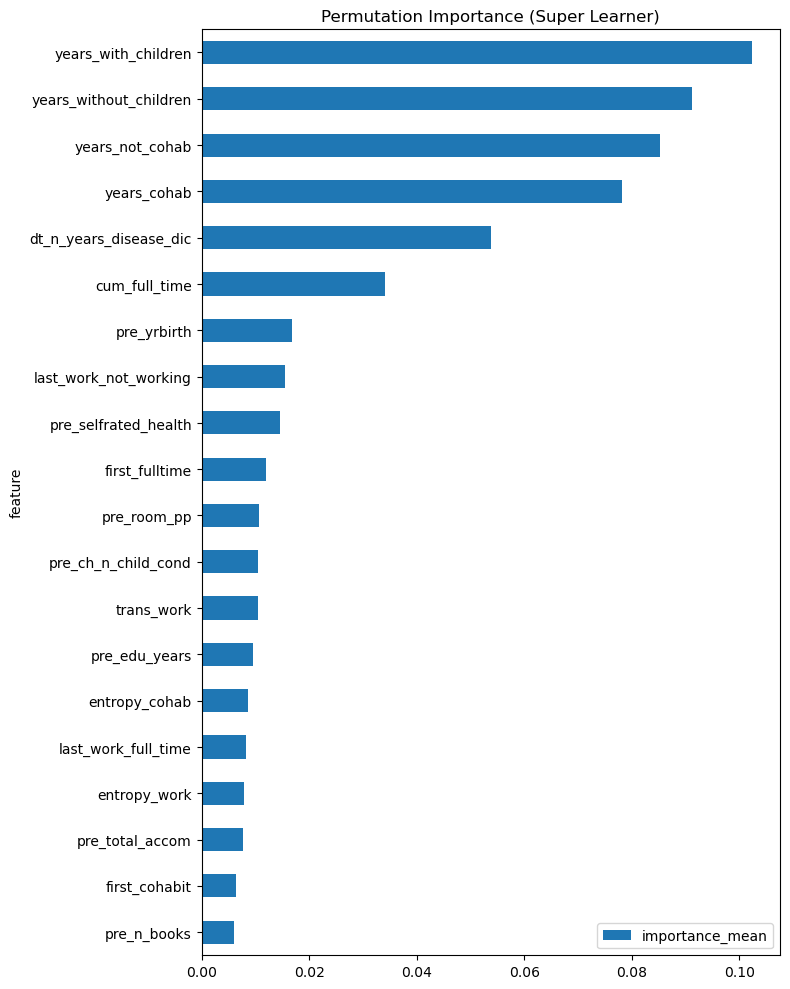

In [30]:
gc.plot_super_learner_permutation_importance(X = X_cor_features_adl_65_75_dic, 
                                             y = y_adl_cor_65_75_dic, 
                                             model = y_adl_cor_super_learner, 
                                             feature_names = trt_features_cor_adl_65_75_dic.columns.tolist(), 
                                             label = "adl 65-75 (cor)", output_dir="model_outputs/adl/cor")


=== Permutation Importance (Super Learner) ===
                    feature  importance_mean  importance_std
3           years_not_cohab         0.114227        0.009646
4       years_with_children         0.093682        0.008280
5    years_without_children         0.074231        0.005766
2               years_cohab         0.046828        0.008466
30   dt_n_years_disease_dic         0.029642        0.008233
0             cum_full_time         0.016103        0.010053
33     pre_selfrated_health         0.010765        0.004857
20      last_work_full_time         0.007709        0.006916
37                pre_rooms         0.006472        0.002246
14               trans_work         0.005115        0.002085
23    last_work_not_working         0.003646        0.005221
1             cum_part_time         0.002862        0.003397
45              pre_migrant         0.002764        0.001855
6   dominant_work_full_time         0.001541        0.002491
24   last_cohab_nc_no_child         0

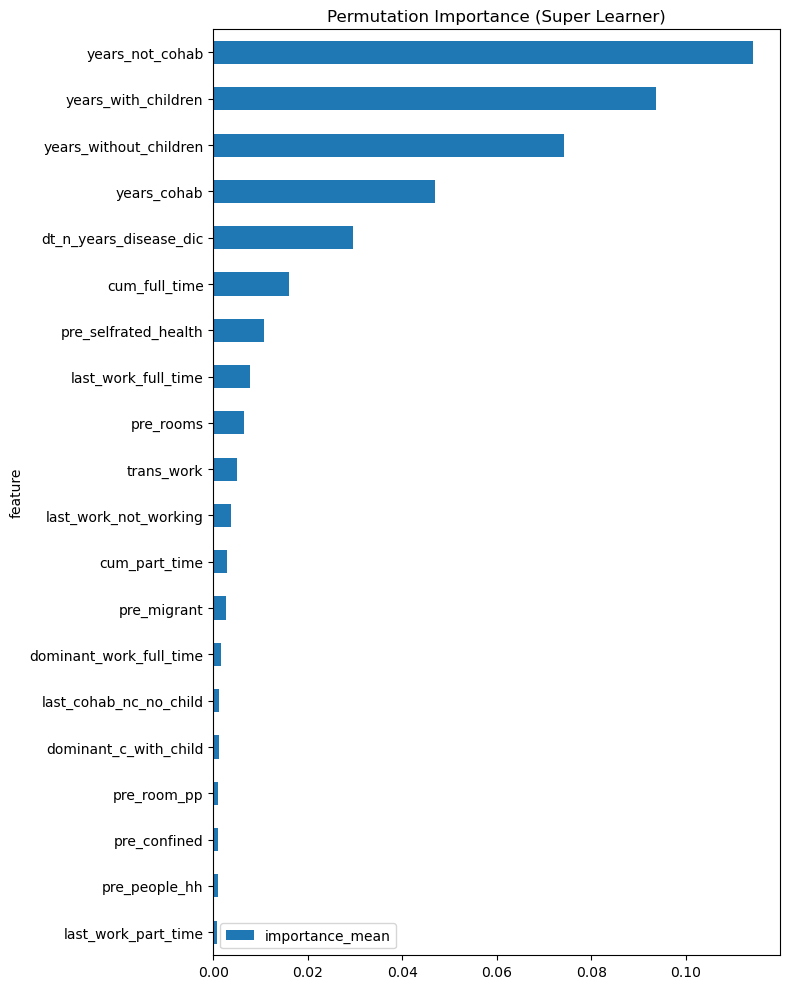


--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.002
 Potential outcome: mean=0.096
 Relative average treatment effects: -0.172: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disease_dic: mean=0.002
 Potential outcome: mean=0.098
 Relative average treatment effects: -0.154: Negative sign meaning less risk of health problem

--- Medoid 3 ---
  Predicted dt_n_years_disease_dic: mean=0.003
 Potential outcome: mean=0.113
 Relative average treatment effects: -0.029: Negative sign meaning less risk of health problem

--- Medoid 0 ---
  Predicted dt_n_years_disease_dic: mean=0.001
 Potential outcome: mean=0.111
 Relative average treatment effects: -0.297: Negative sign meaning less risk of health problem

--- Medoid 1 ---
  Predicted dt_n_years_disease_dic: mean=0.003
 Potential outcome: mean=0.163
 Relative average treatment effects: 0.030: Negative sign meaning less risk of health problem

--- Medoid 2 ---
  Predicted dt_n_years_disea

In [31]:
gc.plot_super_learner_permutation_importance(X = X_scan_features_adl_65_75_dic, 
                                             y = y_adl_scan_65_75_dic, 
                                             model = y_adl_scan_super_learner, 
                                             feature_names = trt_features_scan_adl_65_75_dic.columns.tolist(), 
                                             label = "adl 65-75 (scan)", output_dir="model_outputs/adl/scan")

# Yanji ATT Dev Section

In [25]:
def bootstrap(X, y, seed):
        idx = resample(np.arange(len(X)), replace=True, n_samples=len(X), random_state=seed)
        return X[idx], y[idx]

def update_with_medoids(X_dis, X_mob):
    return gc.generate_updated_list(X_dis, X_medoid_features_65_75_dic, cols_to_replace=30), \
           gc.generate_updated_list(X_mob, X_medoid_features_65_75_dic, cols_to_replace=30)

X_mob_corp, y_mob_corp = bootstrap(X_cor_features_adl_65_75_dic, y_adl_cor_65_75_dic, seed=42+3)
X_dis_corp, _ = bootstrap(X_cor_features_disease_65_75_dic, y_disease_cor_65_75_dic, seed=42+3)

X_dis_corp_updated, X_mob_corp_updated = update_with_medoids(X_dis_corp, X_mob_corp)

In [48]:
X_mob_corp.shape

torch.Size([7381, 48])

In [2]:
cf_y_cor, cf_X_cor, ates_cor, stand_ates_cor, risk_ratios_cor =  gc.counterfactual_y_under_X_medoid_features(
    tv_cov_model=y_disease_cor_super_learner,
    y_model=y_adl_cor_super_learner,
    y_dic=y_mob_corp,
    X_features_disease_65_75_dic_updated_list=X_dis_corp_updated,
    X_features_outcome_65_75_dic_updated_list=X_mob_corp_updated,
    tv_cov_name="dt_n_years_disease_dic",
    outcome_feature_names=trt_features_cor_adl_65_75_dic.columns.tolist()
)

NameError: name 'gc' is not defined

In [27]:
cf_y_cor

{'medoid_0': array([0.10304406, 0.07693514, 0.18467579, ..., 0.09153558, 0.0889869 ,
        0.09864206]),
 'medoid_1': array([0.09975876, 0.07079941, 0.16078363, ..., 0.08561545, 0.08149885,
        0.09121268]),
 'medoid_2': array([0.11200885, 0.08355495, 0.19572129, ..., 0.10110906, 0.09818949,
        0.10721816]),
 'medoid_3': array([0.11857876, 0.08754438, 0.20187727, ..., 0.1062853 , 0.10236349,
        0.11314701])}

In [1]:
ates_cor

NameError: name 'ates_cor' is not defined

In [96]:
df_adl_cor_65_75_results['medoid_0_cf_y_cor'] = cf_y_cor['medoid_0']
df_adl_cor_65_75_results['medoid_0_y_cor'] = y_mob_corp.squeeze().cpu().numpy()

In [107]:
df_adl_cor_65_75_results_summ = df_adl_cor_65_75_results\
    .groupby(['cluster'])\
    .agg({
        'medoid_0_cf_y_cor': 'mean',
        'medoid_0_y_cor': 'mean',
})\
.reset_index()

In [109]:
df_adl_cor_65_75_results_summ['att'] = df_adl_cor_65_75_results_summ['medoid_0_cf_y_cor'] - df_adl_cor_65_75_results_summ['medoid_0_y_cor']

In [110]:
df_adl_cor_65_75_results_summ

,cluster,medoid_0_cf_y_cor,medoid_0_y_cor,att
0,Cluster 1: FT w Child,0.114267,0.152090,-0.037823
1,Cluster 2: FT w/o Child,0.115633,0.160051,-0.044418
2,Cluster 3: UE w Child,0.114722,0.168752,-0.054030
3,Cluster 4: PT w Child,0.114439,0.174623,-0.060184


In [111]:
ates_cor

{'medoid_0': tensor(-0.0474),
 'medoid_1': tensor(-0.0559),
 'medoid_2': tensor(-0.0368),
 'medoid_3': tensor(-0.0316)}